# Simulated-based-inference of 2D Epileptor model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

In [2]:
from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

#from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi
#from sbi.utils.get_nn_models import posterior_nn

In [4]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [5]:
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [6]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI'

In [7]:
Res_dir='Res_Epileptor2D_sde_sbi_fitstatsummary'

### Simulator

In [8]:
def Epileptor2Dmodel(params, constants, sigma, dt, ts):
   
    eta, tau, x_init, z_init  = params[0], params[1], params[2], params[3]
    
    eta.astype(float)
    tau.astype(float)
    x_init.astype(float)
    z_init.astype(float)

    
    # fixed parameters
    I1=constants[0]
    nt=ts.shape[0]
    dt = np.float(dt)
    sigma = np.float(sigma)
    
    # simulation from initial point
    x = np.zeros(nt)  # fast voltage
    z = np.zeros(nt)  # slow voltage
    states=np.zeros((2,nt))

    x[0] = np.float(x_init)    
    z[0] = np.float(z_init) 
    
    for i in range(1, nt):
        dx =1.0 - x[i-1]**3 - 2.0*x[i-1]**2 - z[i-1] + I1   
        dz =(1.0/tau)*(4*(x[i-1]-eta) - z[i-1])
        x[i]=x[i-1] + dt * dx +  np.sqrt(dt)*sigma*np.random.randn()
        z[i]=z[i-1] + dt * dz +  np.sqrt(dt)*sigma*np.random.randn()
        
    states=  np.concatenate((np.array(x).reshape(-1), np.array(z).reshape(-1)))   
    
    return states
     

In [9]:
Epileptor2Dmodel = numba.jit(Epileptor2Dmodel)

In [10]:
def nullclines(X,Y, eta):  
    I1=3.1
    dX =  1.0 - X**3 - 2.0*X**2 - Y + I1 
    dY =  4*(X-eta) - Y
    contour(X, Y, dX, 0, colors='g')
    contour(X, Y, dY, 0, colors='g') 

In [11]:
def root_fuc(roots, eta):   
    xx = empty(1)
    zz = empty(1)
    F = empty(2)
    xx = roots[0]
    zz = roots[1]
    I1=3.1
    F[0] =1.0 - xx**3 - 2.0*xx**2 - zz + I1 
    F[1] =4*(xx-eta) - zz
    return np.array([F[0], F[1]])

In [12]:
X, Z = mgrid[-5.0:5.0:100j, 0.0:10.0:100j]

rGuess=array([[-1.,3.]])

In [13]:
eta_true=-1.5
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


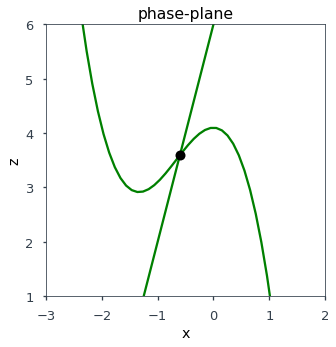

In [14]:
plt.figure(figsize=(5, 5))
nullclines(X,Z,  eta_true)
plt.plot(true_roots[0], true_roots[1] , marker="o", markersize=10, color='k')
plt.xlabel('x'); plt.ylabel('z'); 
plt.title('phase-plane')
plt.xlim((-3,2)), plt.ylim((1,6))
plt.show()

In [15]:
def calculate_summary_statistics(x, params, dt, ts, features):
    """Calculate summary statistics

    Parameters
    ----------
    x : output of the simulator

    Returns
    -------
    np.array, summary statistics
    """

    params.astype(float)

    n_summary = 10

    sum_stats_vec = np.concatenate((np.array([np.mean(x)]),
                                    np.array([np.std(x)]),
                                    np.array([skew(x)]),
                                    np.array([kurtosis(x)]),
                                    ))

    for item in features:

          if item is 'seizures_onset':

                    # initialise array of spike counts
                    nt=ts.shape[0]
                    v=np.zeros(nt)
                    v= np.array(x)

                    v_th=0
                    ind = np.where(v < v_th)
                    v[ind] = v_th

                    ind = np.where(np.diff(v) < 0)
                    v[ind] = v_th

                    spike_times = np.array(ts)[ind]
                    spike_times_stim = spike_times

                    if spike_times_stim.shape[0] > 0:
                            spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim)) > 0.75]

        
                    sum_stats_vec = np.concatenate((sum_stats_vec, 
                                                    np.array([spike_times_stim.shape[0]]),
                                                   ))

            
          if item is 'fixed_point':
                
                    rGuess=array([[-1.,3.]])
                    true_roots = fsolve(root_fuc,rGuess, args=(params[0],))

                    sum_stats_vec = np.concatenate((sum_stats_vec,
                                                    true_roots,
                                                       ))

    sum_stats_vec = sum_stats_vec[0:n_summary]     


    return sum_stats_vec


### sanity check simulations

In [16]:
T = 100.0
dt=0.1
ts = np.arange(0, T + dt, dt)
nt=ts.shape[0]

In [17]:
I1=3.1
constants = np.array([I1])

In [18]:
sigma=1*1e-1

In [19]:
# three sets of params (eta, tau, x0, z0)
params = np.array([[-3.5, 10., -2.5, 3.5],[-2.1, 10., -2.5, 3.5],[-1.5, 10., -2.5, 3.5]])
params.shape

(3, 4)

In [20]:
num_p = len(params[:,0])
sim_p_x = np.zeros((num_p, nt))
sim_p_x_stats = np.zeros((num_p, 7))

num_p,sim_p_x.shape

(3, (3, 1001))

In [21]:
start_time = time.time()
i=0
_ = Epileptor2Dmodel(params[i,:], constants, sigma, dt, ts)
print(" single sim takes (sec):" , (time.time() - start_time))

 single sim takes (sec): 0.7723522186279297


In [22]:
start_time = time.time()
i=0
_ = Epileptor2Dmodel(params[i,:], constants, sigma, dt, ts)
print(" single sim with numba takes (sec):" , (time.time() - start_time))

 single sim with numba takes (sec): 0.0002913475036621094


In [23]:
start_time = time.time()

for i in range(num_p):
    sim_p_x[i,:] = Epileptor2Dmodel(params[i,:], constants, sigma, dt, ts)[0:nt]
    sim_p_x_stats[i,:] = calculate_summary_statistics(sim_p_x[i,:], params[i,:], dt, ts, features=['seizures_onset', 'fixed_point'])
print("similations with numba takes (sec):" , (time.time() - start_time))    

similations with numba takes (sec): 0.0038559436798095703


/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


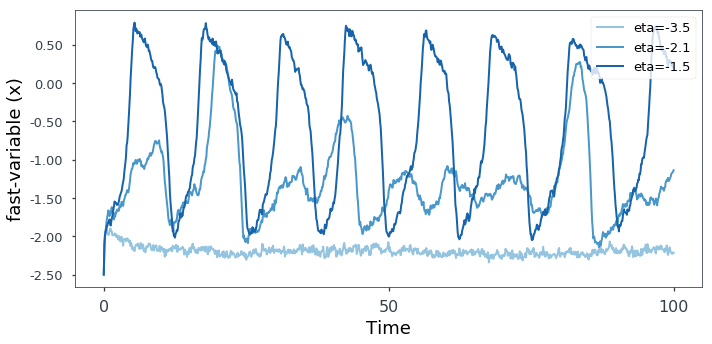

In [24]:
col_min = 2
num_colors = num_p+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]


fig = plt.figure(figsize=(10,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_p):
    plt.plot(ts,sim_p_x[i,:],color=col1[i], lw=2, label='eta='+str(params[i,0]))

plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.legend(loc='upper right')
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_xticks([0, max(ts)/2, max(ts)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.tight_layout();
plt.show()

In [25]:
sim_p_x_stats

array([[-2.19135357,  0.06205066,  1.28920505,  4.20698472,  0.        ,
        -2.21349382,  5.14602471],
       [-1.29939948,  0.52782323,  1.37796081,  1.90779527,  2.        ,
        -1.37058936,  2.91764255],
       [-0.57432166,  0.92968176, -0.15479548, -1.54532532,  8.        ,
        -0.6014927 ,  3.59402919]])

In [26]:
def Epileptor2Dmodel_simulator_wrapper(params):

    params = np.asarray(params)
    
    # time step
    T = 100.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    I1=3.1
    constants = np.array([I1])
    
    sigma=1e-1
    nt=ts.shape[0]
    
    states = Epileptor2Dmodel(params, constants, sigma, dt, ts)

    summstats = torch.as_tensor(calculate_summary_statistics(states[0:nt], params, dt, ts, features=['seizures_onset', 'fixed_point']))

        
    return summstats

## 3. Prior over model parameters

In [27]:
prior_min = [-5.0, 0.1, -5.0, 0.0]
prior_max = [0.0, 50.0, 0.0, 5.0]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### Inference

In [28]:
start_time = time.time()

posterior = infer(Epileptor2Dmodel_simulator_wrapper, prior, method='SNPE', num_simulations=10000, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


Neural network successfully converged after 161 epochs.
------------------------------------------------------------
--- 448.2449064254761 seconds ---


### Data

In [29]:
# true parameters and respective labels
labels_params = [r'$\eta$', r'$\tau$', r'$x_{init}$', r'$z_{init}$']
true_params = np.array([-1.5, 10., -2.5, 3.5])

In [30]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [31]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

In [32]:
x_obs_summary_statistics=calculate_summary_statistics(x_obs, true_params, dt, ts, features=['seizures_onset', 'fixed_point'])

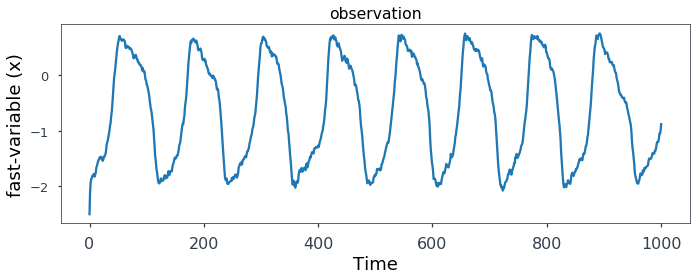

In [33]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs1.eps"), doi=800)
plt.show()

In [34]:
x_obs_summary_statistics

array([-0.65745378,  0.93992186,  0.0380965 , -1.56658815,  8.        ,
       -0.6014927 ,  3.59402919])

### Posterior

In [35]:
num_samples=10000

In [36]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

A Jupyter Widget

In [37]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs1_posterior_samples.npy') , posterior_samples)

In [38]:
num_params=posterior_samples.shape[1]

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


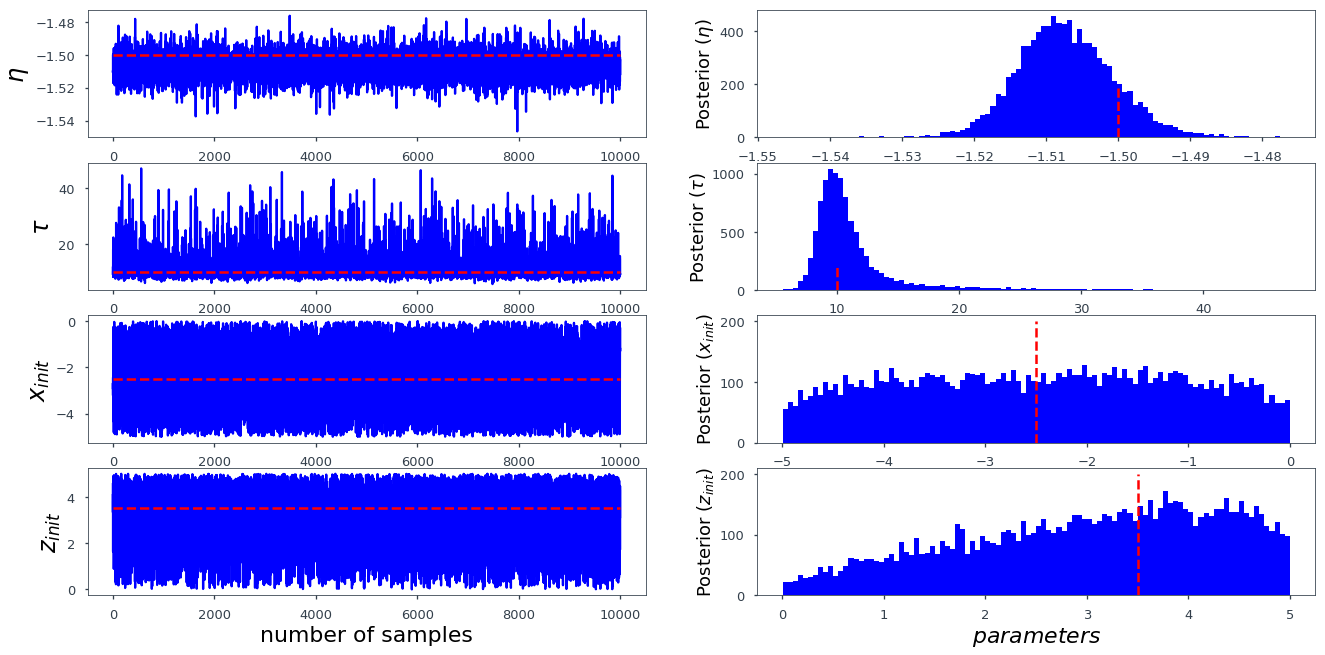

In [39]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.eps"), doi=800)    
plt.show()

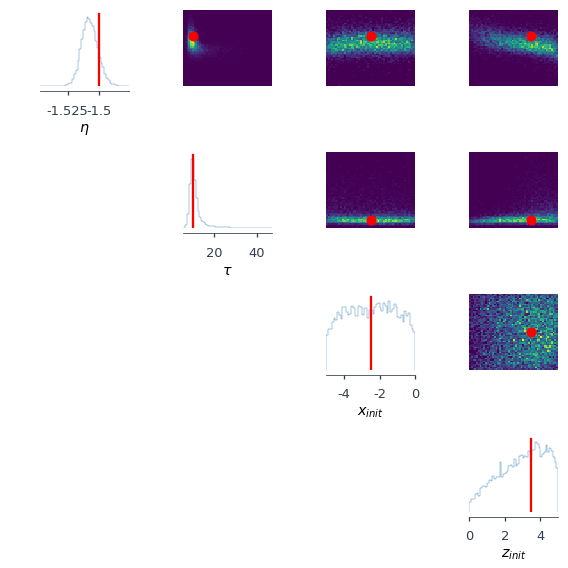

In [40]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs1.eps"), doi=800) 
plt.show()

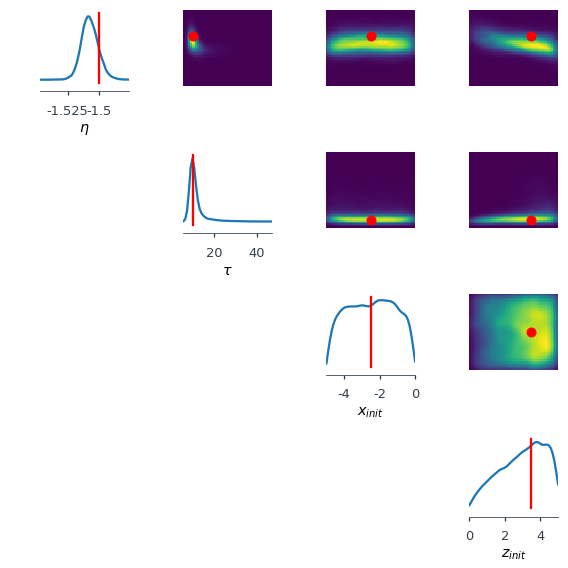

In [41]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs1.eps"), doi=800) 
plt.show()

In [42]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [43]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [44]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs1_y_fit.npy') , y_fit)

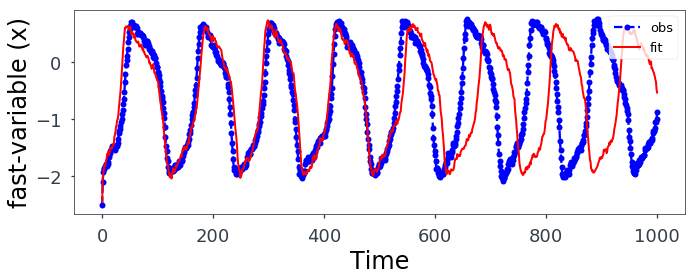

In [45]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs1.eps"), doi=800) 
plt.show()

In [46]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [47]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


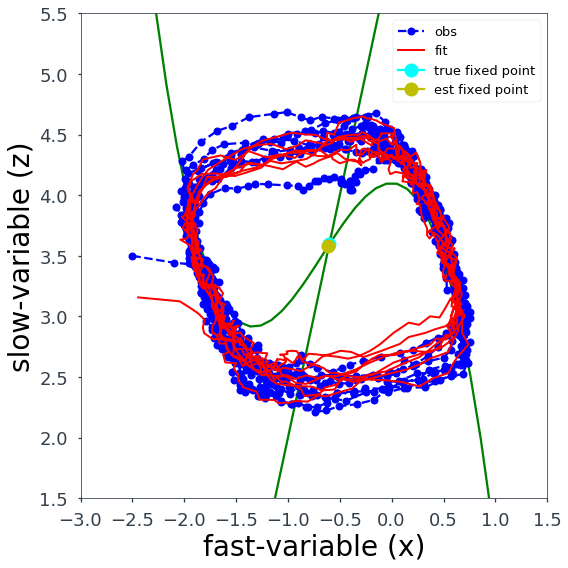

In [48]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '--o', color='b', markersize=8,  label='obs')
plt.plot(x_fit, z_fit, '-', color='r', lw=2, markersize=4,  label='fit')
nullclines(X,Z,  eta_true)
plt.plot(true_roots[0], true_roots[1] , marker="o", markersize=14, color='cyan', label='true fixed point')
plt.plot(est_roots[0], est_roots[1] , marker="o", markersize=14, color='y', label='est fixed point')
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 5.5])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs1.eps"), doi=800) 
plt.show()

### Another Data

In [49]:
true_params = np.array([-2.1, 10., -2.5, 3.5])

In [50]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [51]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

In [52]:
x_obs_summary_statistics=calculate_summary_statistics(x_obs, true_params, dt, ts, features=['seizures_onset', 'fixed_point'])

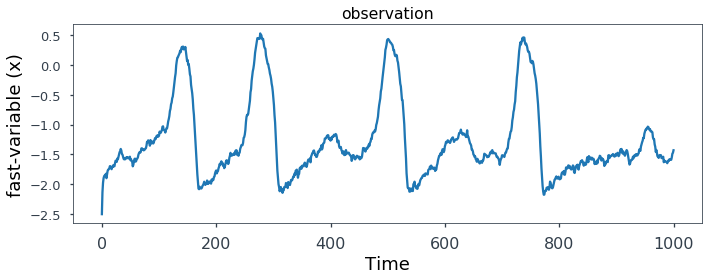

In [53]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs2.eps"), doi=800)
plt.show()

In [54]:
x_obs_summary_statistics

array([-1.28175636,  0.65344279,  1.32338633,  0.85705961,  4.        ,
       -1.37058936,  2.91764255])

### Posterior

In [55]:
num_samples=10000

In [56]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

A Jupyter Widget

In [57]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs2_posterior_samples.npy') , posterior_samples)

In [58]:
num_params=posterior_samples.shape[1]

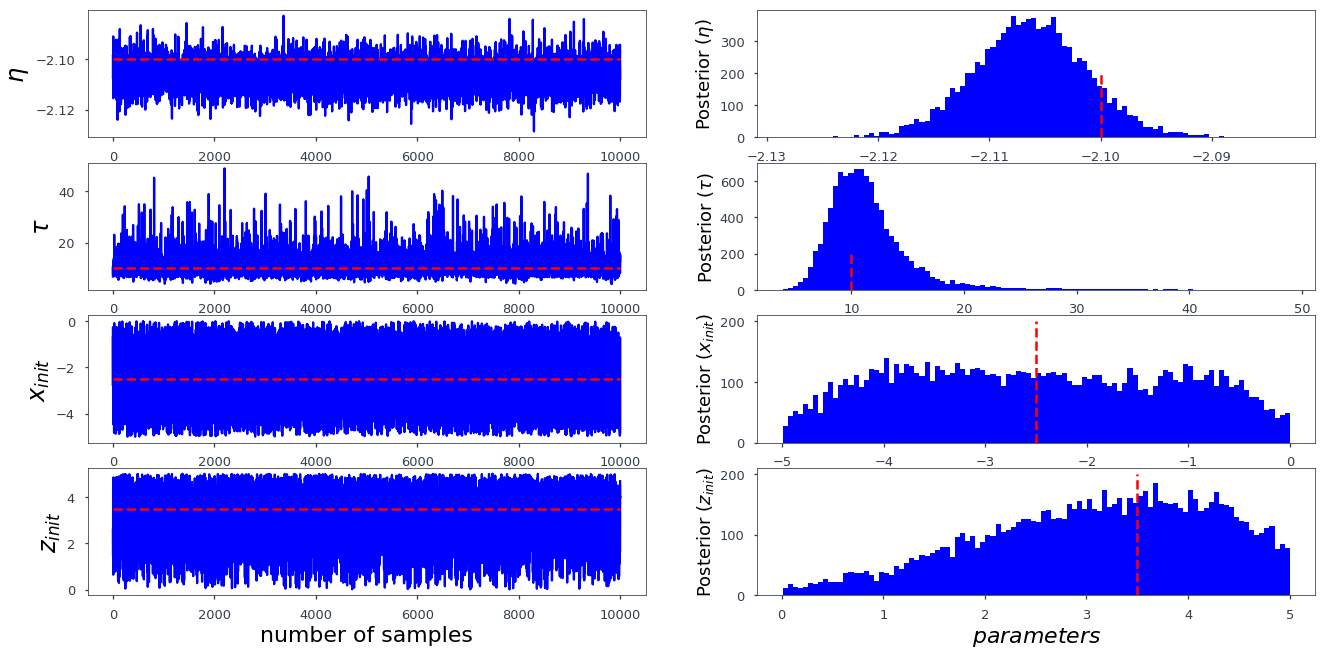

In [59]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.eps"), doi=800)    
plt.show()

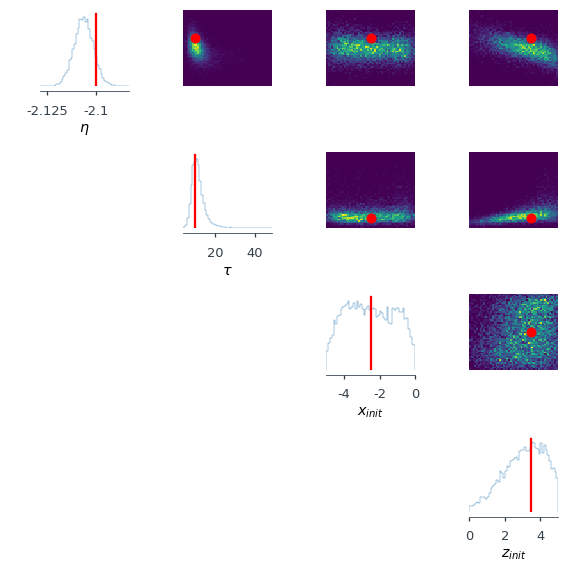

In [60]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs2.eps"), doi=800) 
plt.show()

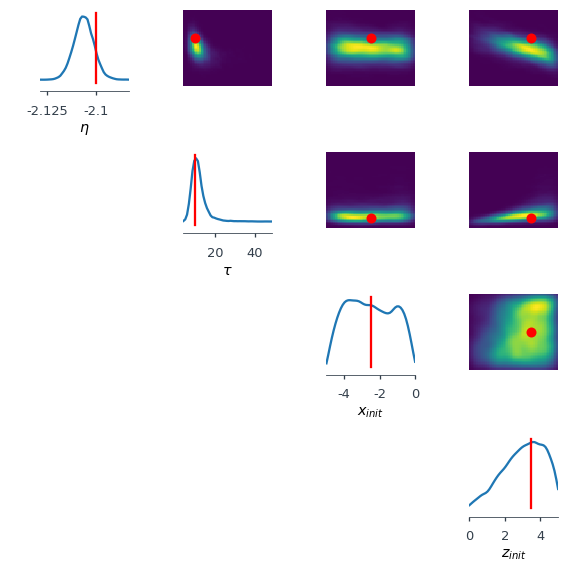

In [61]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs2.eps"), doi=800) 
plt.show()

In [62]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [63]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [64]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs2_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs2_y_fit.npy') , y_fit)

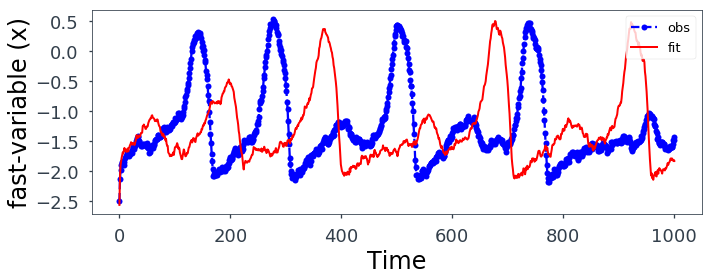

In [65]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs2.eps"), doi=800) 
plt.show()

In [66]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [67]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

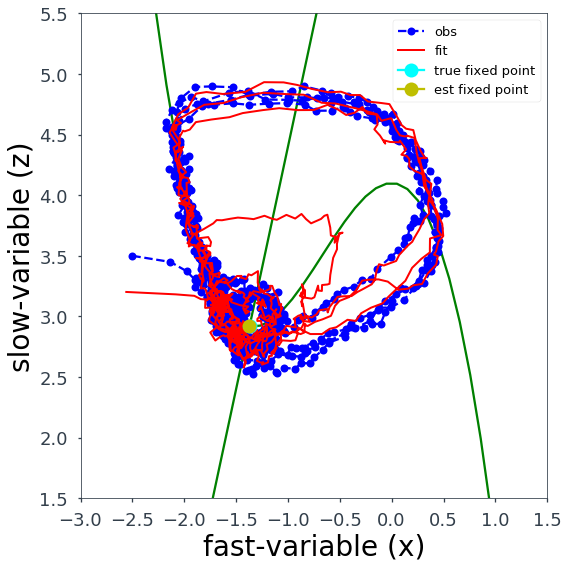

In [68]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '--o', color='b', markersize=8,  label='obs')
plt.plot(x_fit, z_fit, '-', color='r', lw=2, markersize=4,  label='fit')
nullclines(X,Z,  eta_true)
plt.plot(true_roots[0], true_roots[1] , marker="o", markersize=14, color='cyan', label='true fixed point')
plt.plot(est_roots[0], est_roots[1] , marker="o", markersize=14, color='y', label='est fixed point')
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 5.5])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs2.eps"), doi=800) 
plt.show()

### Another Data

In [69]:
true_params = np.array([-2.5, 10., -2.5, 3.5])

In [70]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [71]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

In [72]:
x_obs_summary_statistics=calculate_summary_statistics(x_obs, true_params, dt, ts, features=['seizures_onset', 'fixed_point'])

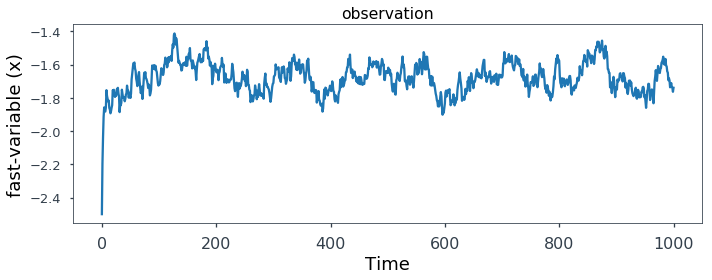

In [73]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs3.eps"), doi=800)
plt.show()

In [74]:
x_obs_summary_statistics

array([-1.6807467 ,  0.09319567, -0.79477127,  6.18783681,  0.        ,
       -1.69436143,  3.22255426])

### Posterior

In [75]:
num_samples=10000

In [76]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

A Jupyter Widget

In [77]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs3_posterior_samples.npy') , posterior_samples)

In [78]:
num_params=posterior_samples.shape[1]

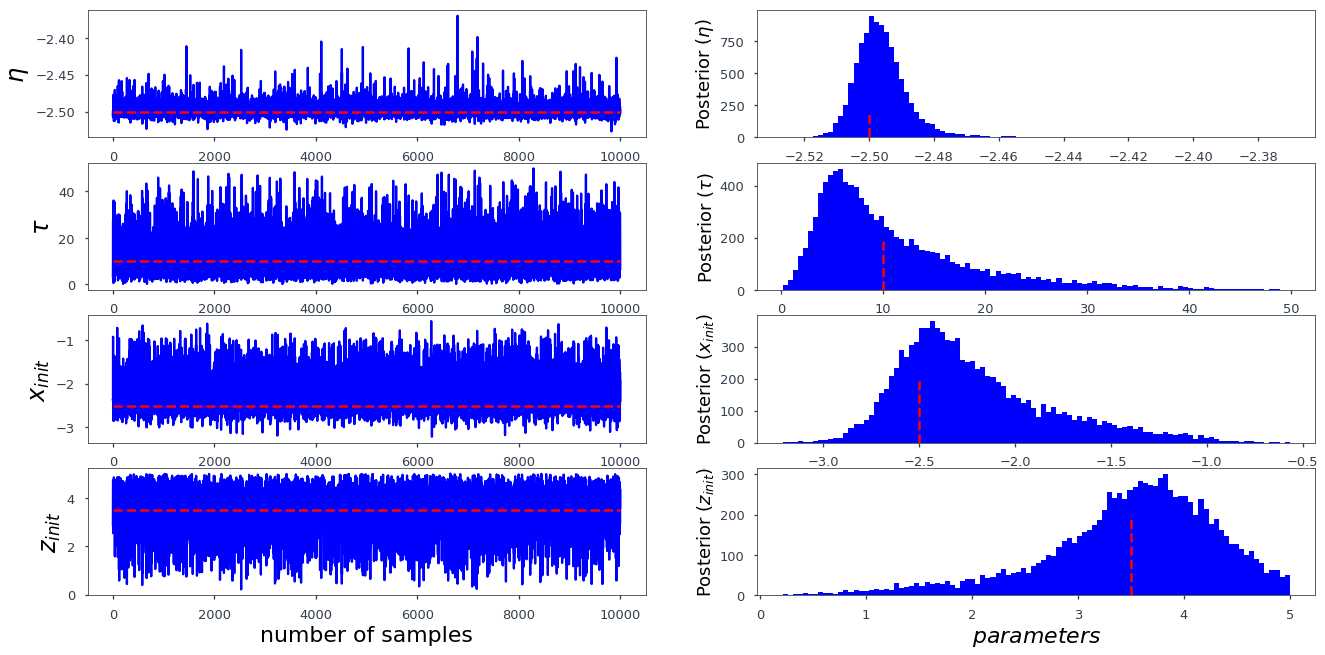

In [79]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.eps"), doi=800)    
plt.show()

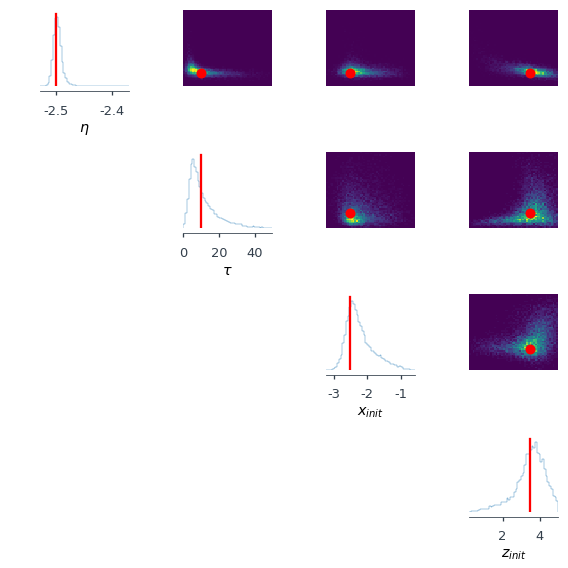

In [80]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs3.eps"), doi=800) 
plt.show()

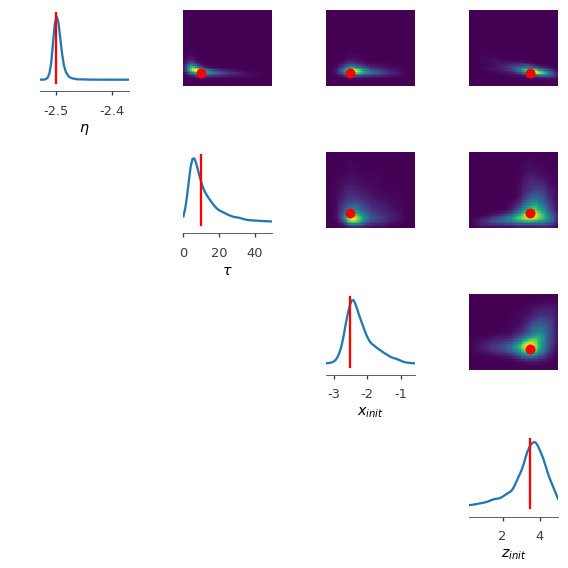

In [81]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs3.eps"), doi=800) 
plt.show()

In [82]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [83]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [84]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs3_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_obs3_y_fit.npy') , y_fit)

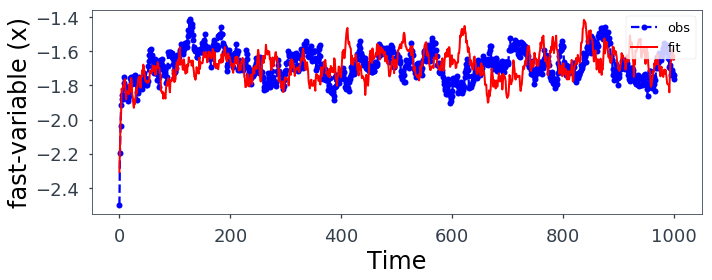

In [85]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs3.eps"), doi=800) 
plt.show()

In [86]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [87]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

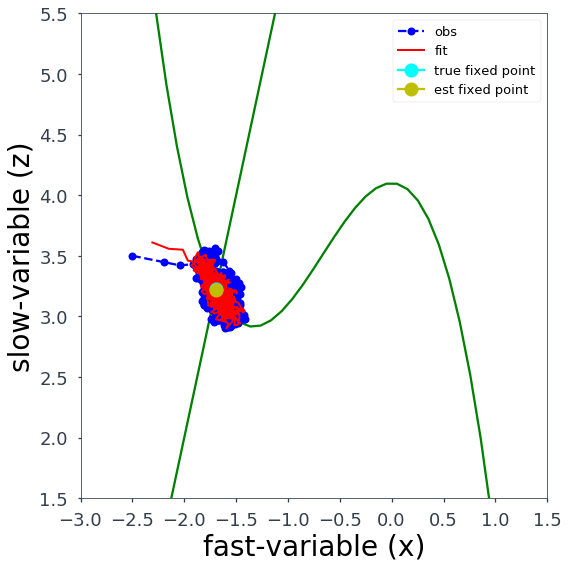

In [88]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '--o', color='b', markersize=8,  label='obs')
plt.plot(x_fit, z_fit, '-', color='r', lw=2, markersize=4,  label='fit')
nullclines(X,Z,  eta_true)
plt.plot(true_roots[0], true_roots[1] , marker="o", markersize=14, color='cyan', label='true fixed point')
plt.plot(est_roots[0], est_roots[1] , marker="o", markersize=14, color='y', label='est fixed point')
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 5.5])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs3.eps"), doi=800) 
plt.show()